# Extending the downdraft calculations to updrafts

Thomas Schanzer  
January 2022

In this notebook, we make minor modifications to extend the downdraft calculations to updrafts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.interpolate import interp1d

from metpy.units import units, concatenate
import metpy.calc as mpcalc
from metpy.plots import SkewT
import metpy.constants as const

from dparcel.thermo import lcl_romps, moist_lapse, saturation_specific_humidity
from dparcel.parcel import IdealisedParcel

## Properties of displaced environmental parcels
This function is unchanged.

In [2]:
def displaced_properties(pressure, temperature, specific_humidity):
    """
    Find the properties of displaced environmental parcels.
    
    Args:
        pressure: Increasing array of pressures at model levels.
        temperature: Array of corresponding temperatures.
        specific_humidity: Array of corresponding specific humidities.
        
    Returns:
        Arrays of temperatures, specific humidities and liquid water
        content with shape (pressure.size, pressure.size), where
        element (i,j) is the value attained by an environmental parcel
        moving adiabatically without entrainment from level i to
        level j.
        
    References:
        Romps, DM 2017, ‘Exact Expression for the Lifting Condensation
        Level’, Journal of the atmospheric sciences, vol. 74,
        no. 12, pp. 3891–3900.
    """
    if np.any(pressure[:-1] >= pressure[1:]):
        raise ValueError('Pressure array must be strictly increasing.')
    
    # Find the LCL using the exact solution of Romps (2017)
    p_lcl, t_lcl = lcl_romps(pressure, temperature, specific_humidity)
    lcl_index = np.searchsorted(pressure, p_lcl)
    
    # initialise empty arrays
    t_disp = np.zeros((pressure.size, pressure.size))*units.kelvin
    q_disp = np.zeros((pressure.size, pressure.size))*units.dimensionless
    l_disp = np.zeros((pressure.size, pressure.size))*units.dimensionless
    
    for i in range(pressure.size):
        if lcl_index[i] < pressure.size:
            # temperatures for j >= lcl_index[i], i.e., below the LCL,
            # are the dry adiabatic values
            t_disp[i,lcl_index[i]:] = mpcalc.dry_lapse(
                pressure[lcl_index[i]:], temperature[i],
                reference_pressure=pressure[i])
            # specific humidity is constant below the LCL and equal
            # to the initial environmental value
            q_disp[i,lcl_index[i]:] = specific_humidity[i]
        if lcl_index[i] > 0:
            # temperatures for j < lcl_index[i], i.e., above the LCL,
            # are the moist pseudoadiabatic values, starting from
            # the known pressure and temperature at the LCL
            t_disp[i,:lcl_index[i]] = moist_lapse(
                pressure[:lcl_index[i]], t_lcl[i],
                reference_pressure=p_lcl[i], method='fast')
            # the specific humidity is the saturation value
            q_disp[i,:lcl_index[i]] = saturation_specific_humidity(
                pressure[:lcl_index[i]], t_disp[i,:lcl_index[i]])
        # assuming total water is conserved, the final specific
        # humidity plus liquid water content equals the initial
        # specific humidity
        l_disp[i,:] = specific_humidity[i] - q_disp[i,:]
    
    # calculate virtual temperatures and buoyancy
    r_disp = mpcalc.mixing_ratio_from_specific_humidity(q_disp)
    tv_disp = mpcalc.virtual_temperature(t_disp, r_disp)
    r_env = mpcalc.mixing_ratio_from_specific_humidity(specific_humidity)
    tv_env = mpcalc.virtual_temperature(temperature, r_env)
    # note that the parcel arrays are 2D while the environment array
    # is 1D: the calculation is performed row-by-row on the 2D arrays,
    # not column-by-column
    b_disp = ((1 - l_disp)*tv_disp - tv_env)/tv_env*const.g
    
    return t_disp, q_disp, l_disp, b_disp

## Properties of heterogeneous thermals

`transition_point` already covers the case where `l_initial == 0` so no changes are needed.

In [3]:
def transition_point(pressure, p_initial, t_initial, q_initial, l_initial):
    """
    Finds the transition point between moist and dry descent.
    
    Only applies to non-entraining parcels.
    For updraft parcels, this is equivalent to an LCL calculation.

    Args:
        pressure: Increasing array of pressures at model levels.
        p_initial: Starting pressure of the parcel.
        t_initial: Initial temperature of the parcel.
        q_initial: Initial specific humidity of the parcel.
        l_initial: Initial liquid water ratio of the parcel.

    Returns:
        The pressure at which the liquid water ratio in the parcel
        becomes zero, and its temperature at that point.
        
    References:
        Romps, DM 2017, ‘Exact Expression for the Lifting Condensation
        Level’, Journal of the atmospheric sciences, vol. 74,
        no. 12, pp. 3891–3900.
    """
    if l_initial <= 0:
        # Romps (2017) LCL calculation is valid
        return lcl_romps(p_initial, t_initial, q_initial)

    # evaluate moist adiabatic values on a coarse array between
    # starting point and the surface in order to bracket the
    # transition point
    p_check = np.arange(
        p_initial.m_as(units.mbar), pressure[-1].m_as(units.mbar), 10
    )*units.mbar
    p_check = concatenate([p_check, pressure[-1]])
    t_moist = moist_lapse(
        p_check, t_initial, reference_pressure=p_initial, method='fast')
    l_moist = (
        q_initial + l_initial
        - saturation_specific_humidity(p_check, t_moist)
    )

    if l_moist[-1] > 0:
        # moist descent only
        return pressure[-1], t_moist[-1]

    # now find the transition point where l == 0
    if np.any(l_moist == 0):
        # check if we have already found the transition point
        return p_check[l_moist == 0][0], t_moist[l_moist == 0][0]

    # choose a suitable bracketing interval for the transition point.
    # out of the levels that give positive l_moist, use the one
    # that gives the smallest l_moist as one end of the interval
    guess_above = p_check[
        np.nanargmin(np.where(l_moist < 0, np.nan, l_moist))
    ]
    # out of the levels that give negative l_moist, use the one
    # that gives the largest l_moist as the other end
    guess_below = p_check[
        np.nanargmax(np.where(l_moist > 0, np.nan, l_moist))
    ]

    # evaluate the parcel properties on a finely spaced array within
    # the bracketing interval and interpolate to find the point of
    # l_moist == 0
    p_check = np.linspace(
        guess_above.m_as(units.mbar), guess_below.m_as(units.mbar), 100
    )*units.mbar
    t_moist = moist_lapse(
        p_check, t_initial, reference_pressure=p_initial, method='fast')
    l_moist = (
        q_initial + l_initial
        - saturation_specific_humidity(p_check, t_moist)
    )
    p_switch = interp1d(l_moist.m, p_check.m)(0)
    t_switch = interp1d(p_check.m, t_moist.m_as(units.kelvin))(p_switch)

    return p_switch.item()*units.mbar, t_switch.item()*units.kelvin

No changes are made to `nonentraining_properties`, other than skipping the unnecessary calculations for any levels below the initial level for updrafts or above for downdrafts.

In [4]:
def nonentraining_properties(
        pressure, p_initial, t_initial, q_initial, l_initial, *, kind):
    """
    Calculate the properties of a non-entraining parcel.
    
    This is valid for both ascent and descent.

    Args:
        pressure: Array of pressures at model levels.
        p_initial: Starting pressure of the parcel.
        t_initial: Initial temperature of the parcel.
        q_initial: Initial specific humidity of the parcel.
        l_initial: Initial liquid water ratio of the parcel.
        kind: 'up' for updrafts, 'down' for downdrafts.

    Returns:
        Arrays of parcel temperatures, specific humidities and
        liquid ratios at the levels of interest.
    """
    p_switch, t_switch = transition_point(
        pressure, p_initial, t_initial, q_initial, l_initial)
    
    t_final = np.zeros(pressure.size)*units.kelvin
    q_final = np.zeros(pressure.size)*units.dimensionless
    l_final = np.zeros(pressure.size)*units.dimensionless

    # descent is moist adiabatic above the transition point and
    # dry adiabatic below the transition point. exclude any levels
    # below the initial level for updrafts, and any above the initial
    # level for downdrafts, to avoid unnecessary calculations.
    if kind == 'up':
        moist_levels = (pressure <= p_switch) & (pressure <= p_initial)
        dry_levels = (pressure > p_switch) & (pressure <= p_initial)
    else:
        moist_levels = (pressure <= p_switch) & (pressure >= p_initial)
        dry_levels = (pressure > p_switch) & (pressure >= p_initial)
    
    if np.any(moist_levels):
        t_final[moist_levels] = moist_lapse(
            pressure[moist_levels], t_switch,
            reference_pressure=p_switch, method='fast')
        q_final[moist_levels] = saturation_specific_humidity(
            pressure[moist_levels], t_final[moist_levels])
        l_final[moist_levels] = q_initial + l_initial - q_final[moist_levels]

    if np.any(dry_levels):
        t_final[dry_levels] = mpcalc.dry_lapse(
            pressure[dry_levels], t_switch, reference_pressure=p_switch)
        q_final[dry_levels] = saturation_specific_humidity(p_switch, t_switch)
        l_final[dry_levels] = 0*units.dimensionless

    return t_final, q_final, l_final

When calculating the weighted average properties of heterogeneous parcels, we ensure that we are integrating upwards: for example, Eq. (10) in Sherwood et al. (2013) for updrafts,
$$
    B(z) = P_0(z) B(z, z_0) + \int_{z_0}^z B(z,z') P(z,z') ~\mathrm{d}z,
$$
takes the form
$$
    B(z) = P_0(z) B(z, z_0) + \int_z^{z_0} B(z,z') P(z,z') ~\mathrm{d}z
$$
for downdrafts.

In [5]:
def heterogeneous_properties(
        i_init, t_initial, q_initial, l_initial, pressure, height,
        temperature, specific_humidity, t_disp, q_disp, l_disp, b_disp,
        entrainment_rate, *, kind):
    """
    Find the properties of a heterogeneous parcel.
    
    The method follows Section 4 of Sherwood et al. (2013).
    
    Args:
        i_init: Index of the starting level for the parcel.
        t_initial: Initial temperature of the parcel.
        q_initial: Initial specific humidity of the parcel.
        l_initial: Initial liquid water ratio of the parcel.
        pressure: Increasing array of pressures at model levels.
        height: Array of heights of model levels.
        temperature: Array of corresponding temperatures.
        specific_humidity: Array of corresponding specific humidities.
        t_disp, q_disp, l_disp, b_disp: Array of displaced environmental
            properties obtained from displaced_properties.
        entrainment_rate: Entrainment rate.
        kind: 'up' for updrafts, 'down' for downdrafts.
        
    Returns:
        Arrays of length pressure.size containing the average
        temperature, specific humidity, liquid content and buoyancy
        of the parcel, weighted by the mass mixing fraction of the
        components.
    
    References:
        SHERWOOD, SC, HERNANDEZ-DECKERS, D, COLIN, M & ROBINSON, F 2013,
        ‘Slippery Thermals and the Cumulus Entrainment Paradox’, Journal
        of the atmospheric sciences, vol. 70, no. 8, pp. 2426–2442.
    """
    # find the properties of the non-entraining initial 'core' component
    # of the parcel
    t_core, q_core, l_core = nonentraining_properties(
        pressure, pressure[i_init], t_initial, q_initial, l_initial, kind=kind)
    r_core = mpcalc.mixing_ratio_from_specific_humidity(q_core)
    tv_core = mpcalc.virtual_temperature(t_core, r_core)
    # TODO: avoid re-calculating r_env and tv_env for every up/downdraft
    r_env = mpcalc.mixing_ratio_from_specific_humidity(specific_humidity)
    tv_env = mpcalc.virtual_temperature(temperature, r_env)
    b_core = ((1 - l_core)*tv_core - tv_env)/tv_env*const.g
    
    # following Eq. (8), (9) of Sherwood et al. (2013):
    # mixing_fraction[i,j] is the proportion of air originally in the
    # parcel at height[i] that remains in the parcel after
    # ascent/descent to height[j], i.e.,
    # mixing_fraction[i,j] = exp(-eps|height[i] - height[j]|).
    mixing_fraction = np.exp(-entrainment_rate*np.abs(
        np.atleast_2d(height) - np.atleast_2d(height).T
    ))
    
    # initialise unused array entries as nan
    t_mix = np.full(pressure.size, np.nan)*units.kelvin
    q_mix = np.full(pressure.size, np.nan)*units.dimensionless
    l_mix = np.full(pressure.size, np.nan)*units.dimensionless
    b_mix = np.full(pressure.size, np.nan)*units.meter/units.second**2
    # values at the initial height are the initial values, no entrainment
    t_mix[i_init] = t_core[i_init]
    q_mix[i_init] = q_core[i_init]
    l_mix[i_init] = l_core[i_init]
    b_mix[i_init] = b_core[i_init]
    
    if kind == 'up':
        dir_ = 1
        end = -1
    else:
        dir_ = -1
        end = pressure.size
    # i_init - dir_ is the index of the first level the parcel
    # encounters after the initial level, and end is one index past
    # the last vertical level in the direction of travel (since range
    # and slice do not include the last value)
    for j in range(i_init - dir_, end, -dir_):  # j is the destination level
        if j - dir_ == -1:
            i_range = slice(i_init, None, -dir_)
        else:
            i_range = slice(i_init, j - dir_, -dir_)
        z_interval = height[i_range].m_as(units.meter)
        
        # following Eq. (10) of Sherwood et al. (2013):
        # integrate the contributions of environmental parcels that
        # are entrained in between the initial and final levels using
        # Simpson's rule
        t_integrand = (
            t_disp[i_range,j].T*entrainment_rate
            * mixing_fraction[i_range,j].T
        ).m_as(units.kelvin/units.meter)
        # add a negative sign to the integral if z_interval is
        # decreasing (i.e., for a downdraft parcel) so that we are
        # always integrating upwards
        t_integral = dir_*simpson(t_integrand, z_interval)*units.kelvin
        t_mix[j] = t_core[j]*mixing_fraction[i_init,j] + t_integral
        
        # same procedure as above for the other variables
        q_integrand = (
            q_disp[i_range,j].T*entrainment_rate
            * mixing_fraction[i_range,j].T
        ).m_as(1/units.meter)
        q_integral = dir_*simpson(q_integrand, z_interval)*units.dimensionless
        q_mix[j] = q_core[j]*mixing_fraction[i_init,j] + q_integral
        
        l_integrand = (
            l_disp[i_range,j].T*entrainment_rate
            * mixing_fraction[i_range,j].T
        ).m_as(1/units.meter)
        l_integral = dir_*simpson(l_integrand, z_interval)*units.dimensionless
        l_mix[j] = l_core[j]*mixing_fraction[i_init,j] + l_integral
        
        b_integrand = (
            b_disp[i_range,j].T*entrainment_rate
            * mixing_fraction[i_range,j].T
        ).m_as(1/units.second**2)
        b_integral = dir_*simpson(b_integrand, z_interval)
        b_integral *= units.meter/units.second**2
        b_mix[j] = b_core[j]*mixing_fraction[i_init,j] + b_integral
        
    return t_mix, q_mix, l_mix, b_mix

## Vertical velocity profile

While for an updraft we found
$$
    w(z) = \sqrt{e^{2\epsilon_w (z_0 - z)} w_0^2 + 2 e^{-2\epsilon_w z} \int_{z_0}^z e^{2\epsilon_w z'} B(z') ~\mathrm{d}z'},
$$
the corresponding solution for a downdraft is
$$
    w(z) = -\sqrt{e^{2\epsilon_w (z - z_0)} w_0^2 + 2 e^{2\epsilon_w z} \int_{z_0}^z e^{-2\epsilon_w z'} B(z') ~\mathrm{d}z'}.
$$

In [6]:
def velocity_profile(
        i_init, w_initial, buoyancy, height, drag=0/units.meter, *, kind):
    """
    Determine the downdraft velocity profile.
    
    Args:
        i_init: Index of the starting level.
        w_initial: Initial velocity. Should be non-positive for
            downdrafts and non-negative for updrafts.
        buoyancy: Array of parcel buoyancies at the given heights.
        height: Array of heights at which the buoyancy is sampled.
        drag: The drag coefficient.
        kind: 'up' for updrafts, 'down' for downdrafts.
        
    Returns:
        An array of length height.size containing the velocity profile.
        For updrafts (downdrafts), any entries for levels below (above)
        i_init or above (below) the highest (lowest) level reached will
        be np.nan.
    """
    velocity = np.full(height.size, np.nan)*units.meter/units.second
    velocity[i_init] = w_initial
    
    if kind == 'up':
        dir_ = 1
        end = -1
    else:
        dir_ = -1
        end = height.size
    # i_init - dir_ is the index of the first level the parcel
    # encounters after the initial level, and end is one index past
    # the last vertical level in the direction of travel (since range
    # and slice do not include the last value)
    for j in range(i_init - dir_, end, -dir_):
        if j - dir_ == -1:
            i_range = slice(i_init, None, -dir_)
        else:
            i_range = slice(i_init, j - dir_, -dir_)
        # implementation of the analytic solution using the integrating
        # factor method, approximating the integral using Simpson's
        # rule
        integrand = np.exp(dir_*2*drag*height[i_range])*buoyancy[i_range]
        integral = simpson(
            integrand.m_as(units.meter/units.second**2),
            height[i_range].m_as(units.meter)
        )*units.meter**2/units.second**2
        v_squared = (
            np.exp(dir_*2*drag*(height[i_init] - height[j]))*w_initial**2
            + 2*np.exp(-dir_*2*drag*height[j])*integral
        )
        
        # v^2 < 0 indicates the thermal cannot reach that level
        velocity[j] = dir_*np.sqrt(v_squared) if v_squared >= 0 else np.nan
    return velocity

## Detrainment profile

We found that the mass $m$ of an ascending parcel satisfies
$$
    \frac{m}{m_0} = \exp \left( -\int_{z_0}^z \nu(z') ~\mathrm{d}z' \right),
$$
while the corresponding expression for a descending parcel is
$$
    \frac{m}{m_0} = \exp \left( \int_{z_0}^z \nu(z') ~\mathrm{d}z' \right).
$$

In [7]:
def detrained_mass(
        height, velocity, buoyancy, dnu_db, entrainment_rate, *, kind):
    """
    Calculate the fractional mass detrained from a thermal at each level.
    
    Args:
        height: Array of heights at model levels.
        velocity: Vertical velocity of the thermal at each level,
            obtained from downdraft_velocity.
        buoyancy: Buoyancy of the thermal at each level.
        dnu_db: The proportionality constant defining the detrainent
            rate nu. When the buoyancy b is negative, nu is zero,
            and when b > 0, nu = b*dnu_db. The units of dnu_db should be
            s^2/m^2.
        entrainment_rate: Entrainment rate.
        kind: 'up' for updrafts, 'down' for downdrafts.
            
    Returns:
        An array of mass detrained at each level, as a fraction of the
        original mass. 
    """
    # velocity is nan for the levels the thermal does not reach:
    # use this to identify starting and ending levels
    reached_levels = np.argwhere(~np.isnan(velocity))
    if kind == 'up':
        # updraft: nu = 0 if b > 0, -b*dnu_db if b < 0
        nu = -np.minimum(buoyancy, 0*units.meter/units.second**2)*dnu_db
        i_init = np.max(reached_levels)
        i_end = np.min(reached_levels)
        dir_ = 1
    else:
        # downdraft: nu = 0 if b < 0, b*dnu_db if b < 0
        nu = np.maximum(buoyancy, 0*units.meter/units.second**2)*dnu_db
        i_init = np.min(reached_levels)
        i_end = np.max(reached_levels)
        dir_ = -1

    m_remaining = np.zeros(height.size)*units.dimensionless
    m_remaining[i_init] = 1*units.dimensionless  # start with 100% mass
    for j in range(i_init - dir_, i_end - dir_, -dir_):
        if j - dir_ == -1:
            i_range = slice(i_init, None, -dir_)
        else:
            i_range = slice(i_init, j - dir_, -dir_)
        # fractional mass remaining = exp(integral_{z_0}^z nu(z') dz')
        integral = simpson(
            nu[i_range].m_as(1/units.meter),
            height[i_range].m_as(units.meter))
        m_remaining[j] = np.exp(-dir_*integral*units.dimensionless)
        
    # thickness of level j is approx. (z_j-1 - z_j+1)/2.
    # pad ends with zeroes to keep same length
    thickness = np.pad((height[:-2] - height[2:])/2, 1)
    thickness[0] = height[0] - height[1]  # topmost layer
    thickness[-1] = height[-2] - height[-1]  # surface layer
    # change in fractional mass is approx. m * nu * delta z
    m_deposited = m_remaining*(entrainment_rate + nu)*thickness
    return np.where(np.isnan(m_deposited), 0*units.dimensionless, m_deposited)

## Testing: downdraft

In [8]:
parcel = IdealisedParcel(0.5)
pressure = np.flip(parcel._pressure_raw*units.mbar)
height = np.flip(parcel._height_raw*units.meter)
temperature = np.flip(parcel._temperature_raw*units.celsius)
specific_humidity = parcel.specific_humidity(parcel.height(pressure))

t_disp, q_disp, l_disp, b_disp = displaced_properties(
    pressure, temperature, specific_humidity)

i_init = np.searchsorted(pressure, parcel.pressure(5*units.km))
t_initial = -13*units.celsius
q_initial = saturation_specific_humidity(pressure[i_init], t_initial)
l_initial = 2e-3*units.dimensionless
rate = 0.5/units.km
w_initial = 0*units.meter/units.second

t_mix, q_mix, l_mix, b_mix = heterogeneous_properties(
    i_init, t_initial, q_initial, l_initial, pressure, height, temperature,
    specific_humidity, t_disp, q_disp, l_disp, b_disp, rate, kind='down')

velocity = velocity_profile(i_init, w_initial, b_mix, height, kind='down')

m_detrained = detrained_mass(
    height, velocity, b_mix, 3e-2*units.second**2/units.meter**2,
    rate, kind='down')

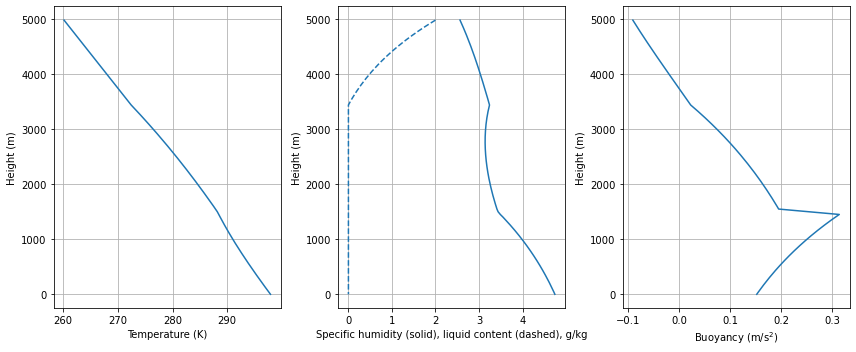

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

ax1.plot(t_mix, height)
ax1.grid()
ax1.set(xlabel='Temperature (K)', ylabel='Height (m)')

ax2.plot(q_mix*1e3, height)
ax2.set_prop_cycle(None)
ax2.plot(l_mix*1e3, height, '--')
ax2.grid()
ax2.set(xlabel='Specific humidity (solid), liquid content (dashed), g/kg',
        ylabel='Height (m)')

ax3.plot(b_mix, height)
ax3.grid()
ax3.set(xlabel='Buoyancy (m/s$^2$)', ylabel='Height (m)')

fig.tight_layout()

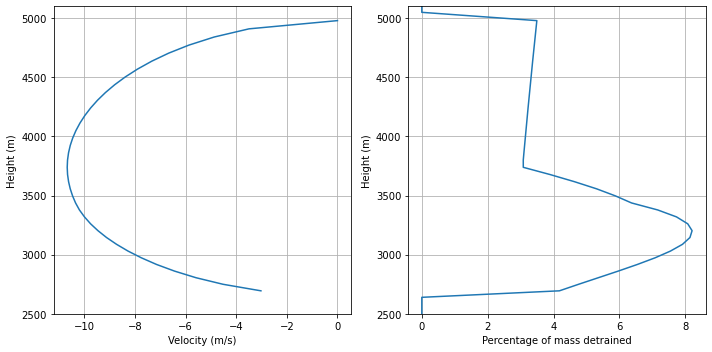

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(velocity, height)
ax1.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
ax2.plot(m_detrained*1e2, height)
ax2.set(xlabel='Percentage of mass detrained', ylabel='Height (m)')
ax1.set_ylim(2500, 5100)
ax2.set_ylim(2500, 5100)
ax1.grid()
ax2.grid()
fig.tight_layout()

## Testing: updraft

In [11]:
i_init = np.searchsorted(pressure, parcel.pressure(0*units.km))
t_initial = parcel.temperature(0*units.km) + 3*units.delta_degC
q_initial = specific_humidity[i_init]
l_initial = 0*units.dimensionless
rate = 0.5/units.km
w_initial = 0*units.meter/units.second

t_mix, q_mix, l_mix, b_mix = heterogeneous_properties(
    i_init, t_initial, q_initial, l_initial, pressure, height, temperature,
    specific_humidity, t_disp, q_disp, l_disp, b_disp, rate, kind='up')

velocity = velocity_profile(i_init, w_initial, b_mix, height, kind='up')

m_detrained = detrained_mass(
    height, velocity, b_mix, 3e-2*units.second**2/units.meter**2,
    rate, kind='up')

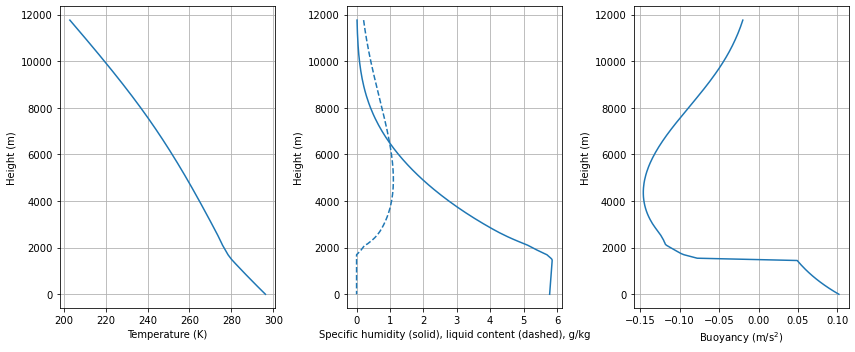

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

ax1.plot(t_mix, height)
ax1.grid()
ax1.set(xlabel='Temperature (K)', ylabel='Height (m)')

ax2.plot(q_mix*1e3, height)
ax2.set_prop_cycle(None)
ax2.plot(l_mix*1e3, height, '--')
ax2.grid()
ax2.set(xlabel='Specific humidity (solid), liquid content (dashed), g/kg',
        ylabel='Height (m)')

ax3.plot(b_mix, height)
ax3.grid()
ax3.set(xlabel='Buoyancy (m/s$^2$)', ylabel='Height (m)')

fig.tight_layout()

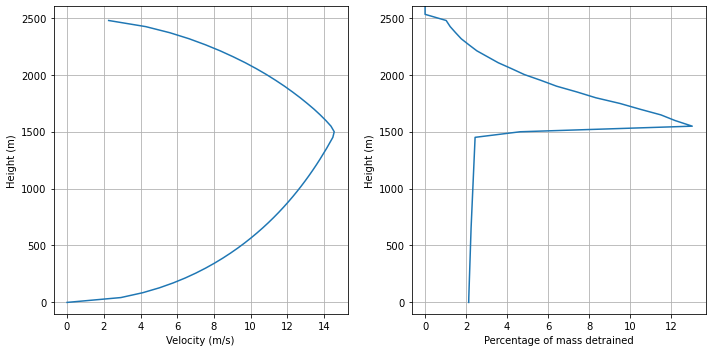

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(velocity, height)
ax1.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
ax2.plot(m_detrained*1e2, height)
ax2.set(xlabel='Percentage of mass detrained', ylabel='Height (m)')
ax1.set_ylim(-100, 2600)
ax2.set_ylim(-100, 2600)
ax1.grid()
ax2.grid()
fig.tight_layout()